In [23]:
import math

class Value:
    def __init__(self, data, _children = (), _operation = '' , _label = ''):
        self.data = data                   # data to be stored 
        self.grad= 0.0                     # to store gradient
        self._backwards = lambda : None    # Function to calculate gradient
        self._prev = set(_children)         # store the _previous datas (childrex) in a set
        self._operation = _operation       # The operation associated with this instance. Defaults to an empty string.
        self._label = _label


    def __repr__(self):
        # used for printing the object 
        return f"data(data={self.data} label={self._label} operation={self._operation})"

    #OPERATIONS
    def __add__(self, other , _label =''):
        # a+b internally a.__add__(b)
        out = Value(self.data + other.data , _children = (self, other) , _operation = '+', _label =_label)

        def _backwards():
            self.grad  = out.grad
            other.grad = out.grad
        out._backwards = _backwards
        return out    

    def __mul__(self, other, _label = ''):
        # a*b internally a.__mul__(b)
        out = Value(self.data * other.data , _children = (self, other) , _operation = '*' , _label =_label)
        def _backwards():
            self.grad  = other.data * out.grad
            other.grad = self.data * out.grad
        out._backwards = _backwards
        return out
    
    #ACTIVATION FUNCTIONS
    def tanh(self):
        x=self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t , _children=(self,), _operation= "tanh")

        def _backwards():
            self.grad = (1-t**2) * out.grad
        out._backwards = _backwards
        return out
    
    

In [2]:
a = Value(2.0,_label="a")
b= Value(-3.0,_label='b')
c = Value(10.0,_label= 'c')
e = a*b
e._label= 'e'
d= e+c
d._label= 'd'
f=Value(-2.0 , _label='f')
L =d*f
L._label= 'L'



In [3]:
from graphviz import Digraph

def trace(root):
    """
    Traverses a tree structure starting from the given root node and builds sets of nodes and edges.

    Args:
        root: The root node of the tree to be traversed.

    Returns:
        A tuple containing two sets:
            - nodes: A set of all nodes in the tree.
            - edges: A set of tuples representing the edges between nodes in the tree.
    """
    nodes , edges = set() ,set() # to 
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child ,node))
                build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root , format = 'svg', rankdir = 'LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR','TB']
    
    nodes, edges= trace(root)
    dot = Digraph(format = format, graph_attr= {'rankdir':rankdir})

    
        
    for node in nodes: 
        uid_for_node= str(id(node))
        dot.node(name = uid_for_node, label = f"{{ {node._label} | {node.data:.4f} | {node.grad:.4f} }}", shape = "record" )

        if node._operation:
            uid_for_operation = uid_for_node + node._operation
            dot.node(name= uid_for_operation, label = f"{node._operation}")
            dot.edge(uid_for_operation, uid_for_node) # connect operation to node
    for node1 , node2 in edges:
        dot.edge(str(id(node1)), str(id(node2))+node2._operation)
        
    
    return dot
        
    

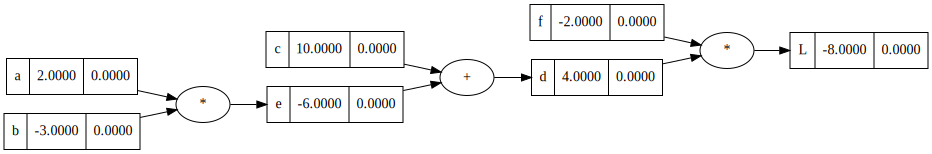

In [4]:
draw_dot(L)

## Gradient Calculation

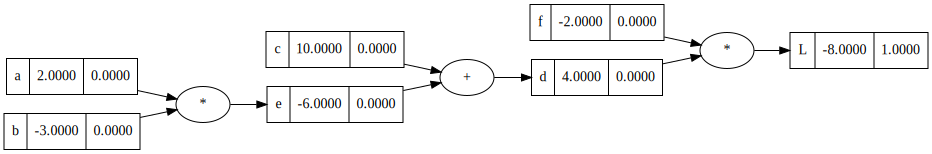

In [5]:
#dL/dL == 1
L.grad = 1.0
draw_dot(L)

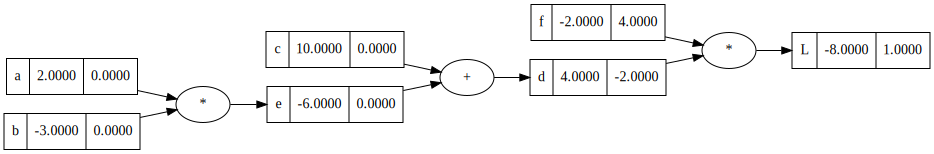

In [6]:
#dL/dd   L=d*f therefore dL/dd = e
# and dL/df = d
d.grad = f.data
f.grad = d.data
draw_dot(L)

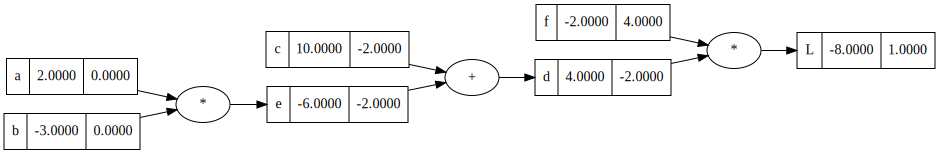

In [7]:
"""
We want :
dL/de = ?
We have :
dL/dd and dd/de -> local gradient d=e+c dd/de =1 

using CHAIN RULE :
dL/de = (dL/dd)*(dd/de)
"""
e.grad = d.grad * 1.0
# same for c
c.grad = d.grad * 1.0
draw_dot(L)

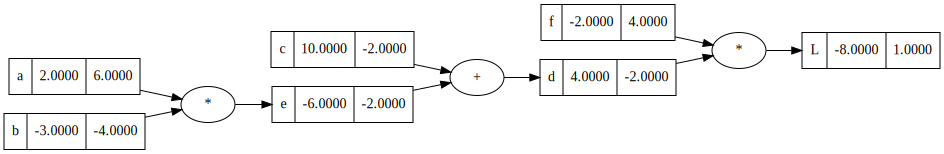

In [8]:
"""
dL/da = (dL/de)*(de/da)
"""
a.grad = e.grad*b.data
b.grad = e.grad*a.data
draw_dot(L)

## Single Layer with 2 Neurons

In [17]:
# Layer = w1x1 + w2x2 + b
w1 = Value(-3.0 , _label= "w1")
w2 = Value(1.0  , _label= "w2")
x1 = Value(2.0  , _label= "x1")
x2 = Value(0.0  , _label= "x2")
b  = Value(6.8813735870195432  , _label=  "b")
w1x1 = w1*x1
w2x2 = w2*x2
w1x1Xw2x2 = w1x1 + w2x2
Layer=  w1x1Xw2x2+ b
Output = Layer.tanh()
w1x1._label = 'w1x1'
w2x2._label = 'w2x2'
w1x1Xw2x2._label = 'w1x1Xw2x2'
Layer._label = "Layer"
Output._label = "Output"


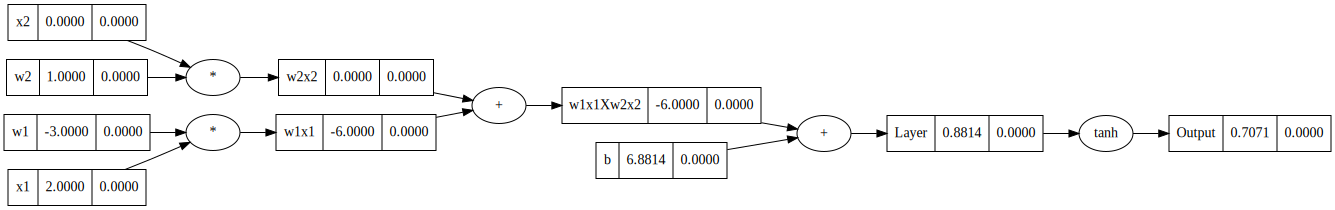

In [18]:
draw_dot(Output)


### Manual Gradient Calculations

In [11]:
# dO/dO O= tanh
Output.grad = 1

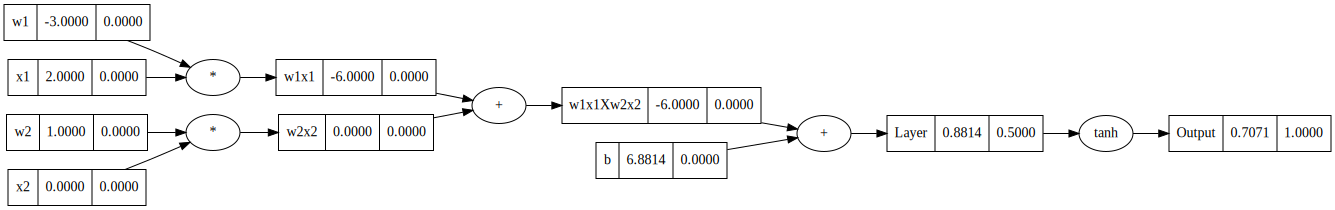

In [12]:
"""dO/dLayer = d(tanh(x))/dx
d(tanh(x))/dx = 1- tanh(x)**2
"""
Layer.grad = 1- Output.data**2
draw_dot(Output)


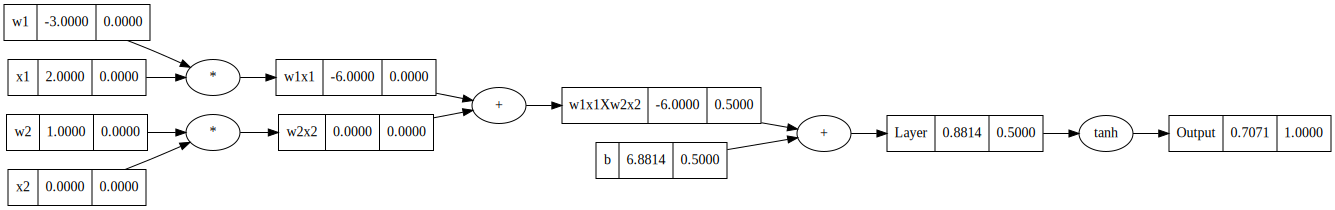

In [13]:
b.grad = w1x1Xw2x2.grad = Layer.grad
draw_dot(Output)

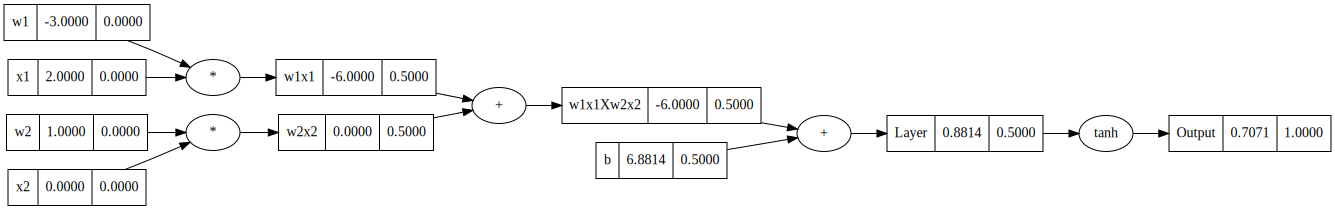

In [14]:
w1x1.grad =w2x2.grad = w1x1Xw2x2.grad
draw_dot(Output)

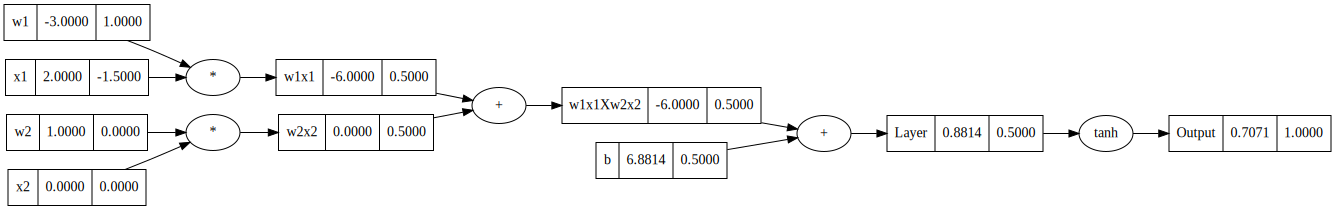

In [15]:
x1.grad = w1x1.grad* w1.data
w1.grad = w1x1.grad* x1.data

draw_dot(Output)

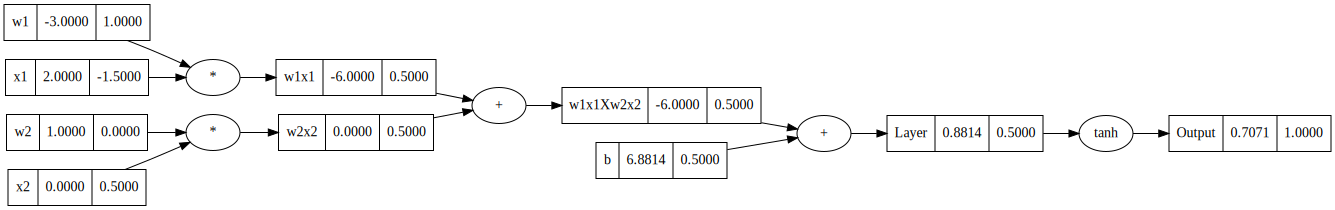

In [16]:
x2.grad = w2x2.grad* w2.data
w2.grad = w2x2.grad* x2.data
draw_dot(Output)


### Using _backwards() method to calculat gradiemts

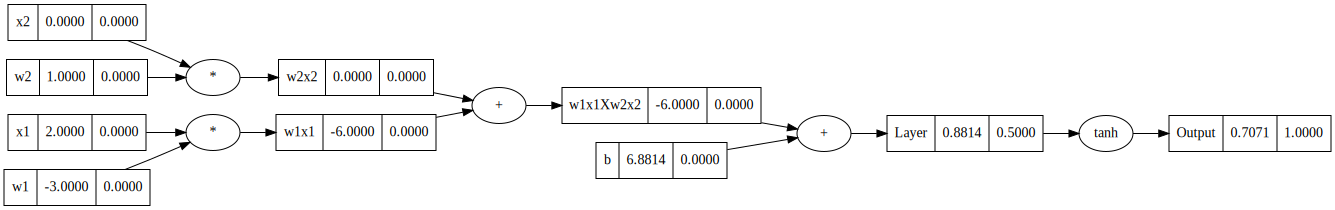

In [11]:
Output.grad = 1
Output._backwards()
draw_dot(Output)


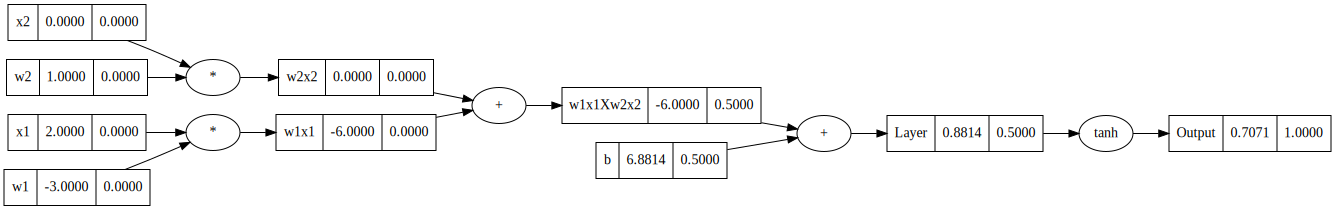

In [12]:
Layer._backwards()
draw_dot(Output)


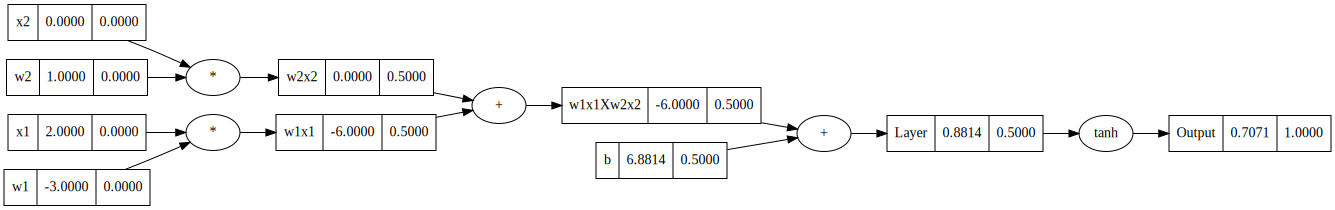

In [13]:
w1x1Xw2x2._backwards()
draw_dot(Output)


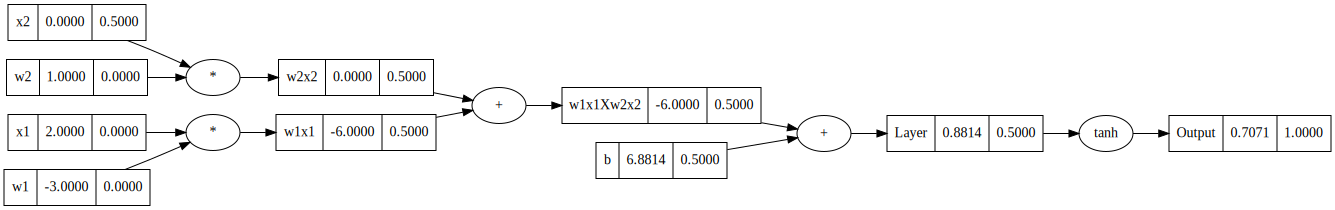

In [15]:
w2x2._backwards()
draw_dot(Output)

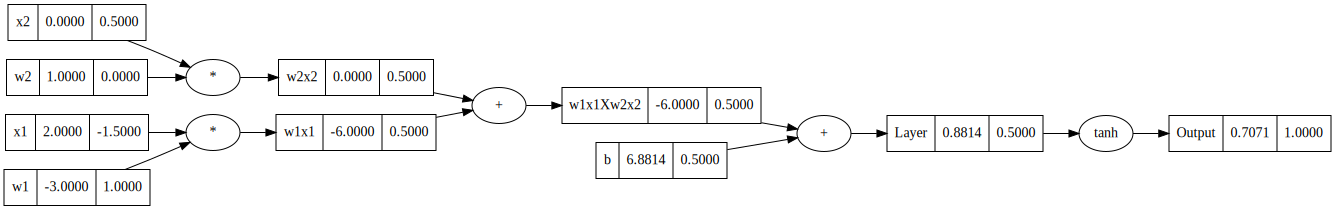

In [16]:
w1x1._backwards()
draw_dot(Output)


### instead of calling  ._backwards again and again we use Topological sort on this as it is a DAG

In [24]:
def backwards(root):
    visited =set()
    topo_ordering = []

    def build_topo(node):
        if node not in visited:
            visited.add(node)
            for child in node._prev:
                build_topo(child)
            
            topo_ordering.append(node)
    build_topo(root)
    for node in reversed(topo_ordering):
        node._backwards()



In [25]:
backwards(Output)
draw_dot(Output)

AttributeError: 'Value' object has no attribute '_prev'